In [1]:
# Import necessary libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#STEP 1: COLLECT DATA

# Upload Divvy datasets (csv files) here
q1_2019 = pd.read_csv("Divvy_Trips_2019_Q1.csv")
q1_2020 = pd.read_csv("Divvy_Trips_2020_Q1.csv")


In [3]:
# STEP 2: WRANGLE DATA AND COMBINE INTO A SINGLE FILE

# Rename columns to make them consistent with q1_2020
q1_2019 = q1_2019.rename(columns={
    'trip_id': 'ride_id',
    'bikeid': 'rideable_type',
    'start_time': 'started_at',
    'end_time': 'ended_at',
    'from_station_name': 'start_station_name',
    'from_station_id': 'start_station_id',
    'to_station_name': 'end_station_name',
    'to_station_id': 'end_station_id',
    'usertype': 'member_casual'
})

# Convert ride_id and rideable_type to str
q1_2019['ride_id'] = q1_2019['ride_id'].astype(str)
q1_2019['rideable_type'] = q1_2019['rideable_type'].astype(str)

# Stack individual quarter's data frames into one big data frame
all_trips = pd.concat([q1_2019, q1_2020], ignore_index=True)

# Remove unnecessary fields
all_trips = all_trips.drop(columns=['start_lat', 'start_lng', 'end_lat', 'end_lng', 'birthyear', 'gender', 'tripduration'])

In [4]:
# STEP 3: CLEAN UP AND ADD DATA TO PREPARE FOR ANALYSIS

# Consolidate labels in the "member_casual" column
all_trips['member_casual'] = all_trips['member_casual'].replace({
    'Subscriber': 'member',
    'Customer': 'casual'
})

# Add columns for date, month, day, year, and day_of_week
all_trips['date'] = pd.to_datetime(all_trips['started_at']).dt.date
all_trips['month'] = pd.to_datetime(all_trips['date']).dt.month
all_trips['day'] = pd.to_datetime(all_trips['date']).dt.day
all_trips['year'] = pd.to_datetime(all_trips['date']).dt.year
all_trips['day_of_week'] = pd.to_datetime(all_trips['date']).dt.day_name()

# Add a "ride_length" calculation (in seconds)
all_trips['ride_length'] = pd.to_datetime(all_trips['ended_at']) - pd.to_datetime(all_trips['started_at'])
all_trips['ride_length'] = all_trips['ride_length'].dt.total_seconds()

# Convert "ride_length" from timedelta to numeric
all_trips['ride_length'] = all_trips['ride_length'].astype(float)

# Remove "bad" data
all_trips_v2 = all_trips[(all_trips['start_station_name'] != "HQ QR") & (all_trips['ride_length'] >= 0)]


Mean ride length: 1189.4586882080314
Median ride length: 539.0
Max ride length: 10632022.0
Min ride length: 1.0
member_casual
casual    5372.783874
member     795.252339
Name: ride_length, dtype: float64
member_casual
casual    1393.0
member     508.0
Name: ride_length, dtype: float64
member_casual
casual    10632022.0
member     6096428.0
Name: ride_length, dtype: float64
member_casual
casual    2.0
member    1.0
Name: ride_length, dtype: float64
member_casual  day_of_week
casual         Friday         6090.737302
               Monday         4752.050438
               Saturday       4950.770801
               Sunday         5061.304364
               Thursday       8451.666853
               Tuesday        4561.803857
               Wednesday      4480.372432
member         Friday          796.733789
               Monday          822.311202
               Saturday        974.072964
               Sunday          972.938336
               Thursday        707.209274
               Tu

C:\Users\shaki\AppData\Local\Temp\ipykernel_888\1008611541.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_trips_v2['day_of_week'] = pd.Categorical(all_trips_v2['day_of_week'], categories=days_order, ordered=True)


member_casual  day_of_week
casual         Sunday         5061.304364
               Monday         4752.050438
               Tuesday        4561.803857
               Wednesday      4480.372432
               Thursday       8451.666853
               Friday         6090.737302
               Saturday       4950.770801
member         Sunday          972.938336
               Monday          822.311202
               Tuesday         769.441629
               Wednesday       711.983790
               Thursday        707.209274
               Friday          796.733789
               Saturday        974.072964
Name: ride_length, dtype: float64


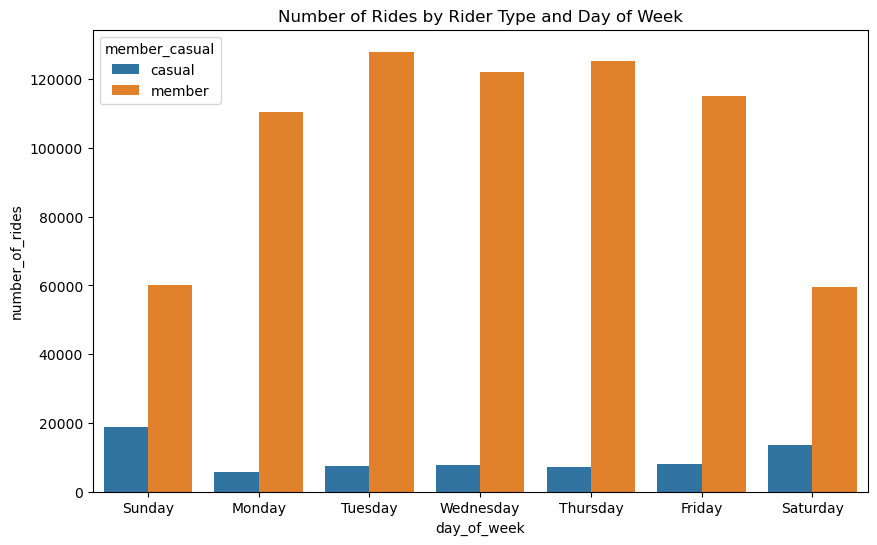

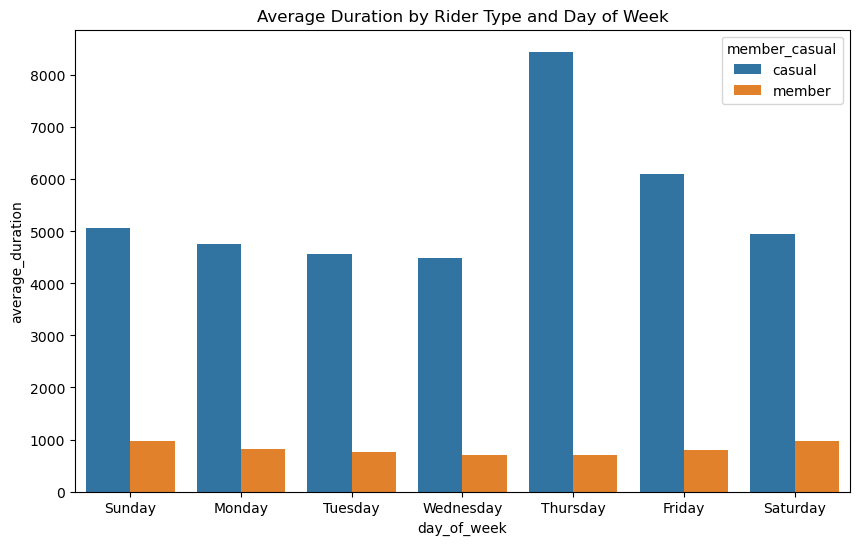

In [5]:
# STEP 4: CONDUCT DESCRIPTIVE ANALYSIS

# Descriptive analysis on ride_length (all figures in seconds)
print("Mean ride length:", all_trips_v2['ride_length'].mean())
print("Median ride length:", all_trips_v2['ride_length'].median())
print("Max ride length:", all_trips_v2['ride_length'].max())
print("Min ride length:", all_trips_v2['ride_length'].min())

# Compare members and casual users
print(all_trips_v2.groupby('member_casual')['ride_length'].mean())
print(all_trips_v2.groupby('member_casual')['ride_length'].median())
print(all_trips_v2.groupby('member_casual')['ride_length'].max())
print(all_trips_v2.groupby('member_casual')['ride_length'].min())

# See the average ride time by each day for members vs casual users
print(all_trips_v2.groupby(['member_casual', 'day_of_week'])['ride_length'].mean())

# Notice that the days of the week are out of order. Let's fix that.
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
all_trips_v2['day_of_week'] = pd.Categorical(all_trips_v2['day_of_week'], categories=days_order, ordered=True)

# Now, let's run the average ride time by each day for members vs casual users
print(all_trips_v2.groupby(['member_casual', 'day_of_week'])['ride_length'].mean())

# Analyze ridership data by type and weekday
ridership_analysis = all_trips_v2.groupby(['member_casual', 'day_of_week']).agg(
    number_of_rides=('ride_id', 'count'),
    average_duration=('ride_length', 'mean')
).reset_index().sort_values(by=['member_casual', 'day_of_week'])

# Let's visualize the number of rides by rider type
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='number_of_rides', hue='member_casual', data=ridership_analysis, dodge=True)
plt.title('Number of Rides by Rider Type and Day of Week')
plt.show()

# Let's create a visualization for average duration
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='average_duration', hue='member_casual', data=ridership_analysis, dodge=True)
plt.title('Average Duration by Rider Type and Day of Week')
plt.show()


In [6]:
# STEP 5: EXPORT SUMMARY FILE FOR FURTHER ANALYSIS

# Create a csv file for further analysis
counts = all_trips_v2.groupby(['member_casual', 'day_of_week'])['ride_length'].mean().reset_index()
counts.to_csv('avg_ride_length.csv', index=False)
